<a href="https://colab.research.google.com/github/RamadanCRaji/flu_shot_prediction/blob/main/flu_shot_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Business Problem - Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines

## Section 1: Business Context & Problem Statement




## **INTRODUCTION (Section 1: Business Context & Problem Statement)**

**Client:** A regional public health department in the Midwest preparing for the upcoming flu season.

**Challenge:** The department's community health outreach budget allows direct intervention for only 20% of the population. In previous years, the department relied on broad demographic targeting, focusing on elderly populations and healthcare workers, but this approach has consistently underperformed. Last flu season, despite reaching their target contact numbers, overall vaccination rates increased by only 2%, well below the 8% improvement needed to achieve herd immunity thresholds in vulnerable communities. Post-season analysis revealed the core problem: outreach efforts were reaching individuals already inclined to vaccinate while missing the hesitant populations who needed intervention most.

**Why This Matters:** Each 1% gap in vaccination coverage translates to approximately 150-200 preventable hospitalizations, 10-15 deaths among high-risk populations, and $1.2 million in avoidable healthcare costs within the department's service area. The department cannot afford another season of inefficient outreach.

**Our Task:** Build a predictive model that identifies individuals least likely to vaccinate without intervention, enabling the health department to prioritize outreach where it will have the greatest impact.

**How the Model Will Be Used:**
1. Rank individuals by predicted vaccination probability for targeted outreach
2. Identify which factors most strongly influence vaccination decisions
3. Design targeted interventions based on key predictive features

## Section 2: Setup & Data Loading

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

**Loading the data**

In [ ]:
train_features = pd.read_csv('training_set_features.csv')
train_labels = pd.read_csv('training_set_labels.csv')
test_features = pd.read_csv('test_set_features.csv')

print(f"Training features shape: {train_features.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test features shape: {test_features.shape}")


Training features shape: (26707, 36)
Training labels shape: (26707, 3)
Test features shape: (26708, 36)


**Merging features and labels on respondent_id**

In [ ]:
train_df = train_features.merge(train_labels, on='respondent_id')
print(f"Merged training data shape: {train_df.shape}")

Merged training data shape: (26707, 38)


** A preview of the merged data**

In [ ]:
train_df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


## Section 3: Exploratory Data Analysis (EDA)

In [ ]:
# basic info about the dataset
print(f"Total samples: {len(train_df)}")
print(f"Total features: {len(train_df.columns) - 3}")  # Here I removed the id and 2 targets variables
print()
train_df.info()

Total samples: 26707
Total features: 35

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        2573

In [ ]:
# looking at the numerical summary
train_df.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,...,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,...,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,...,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,...,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,...,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,...,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,1.000000,1.000000


**checking  the target variables distribution**

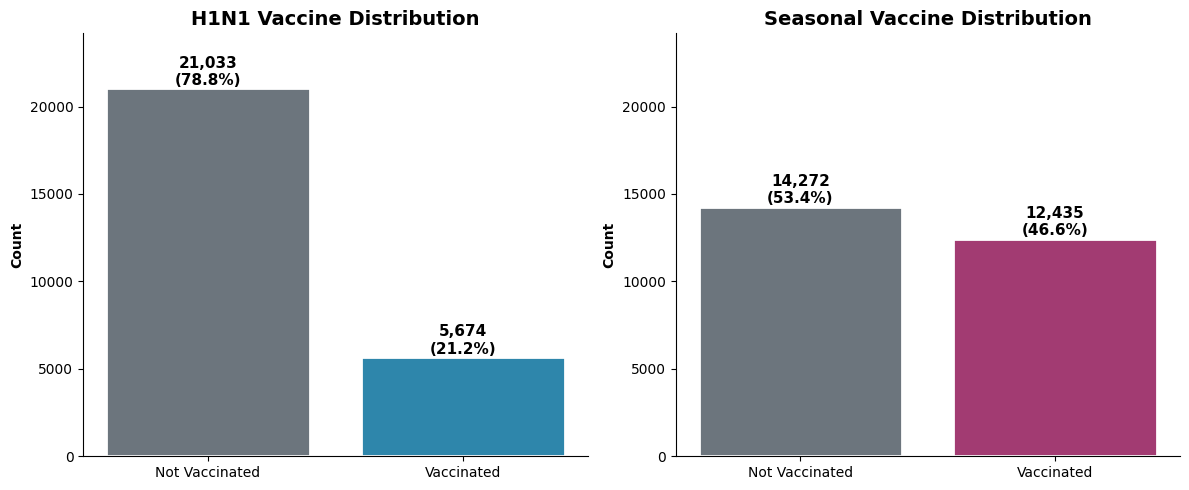

In [ ]:
# visualizing the target variable distribution with percentages
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# H1N1 vaccine
h1n1_counts = train_df['h1n1_vaccine'].value_counts().sort_index()
bars1 = axes[0].bar(['Not Vaccinated', 'Vaccinated'], h1n1_counts.values,
                    color=['#6C757D', '#2E86AB'], edgecolor='white', linewidth=2)
axes[0].set_title('H1N1 Vaccine Distribution', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Count', fontweight='bold')

# adding percentage labels
total = h1n1_counts.sum()
for bar, count in zip(bars1, h1n1_counts.values):
    pct = count / total * 100
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
                f'{count:,}\n({pct:.1f}%)', ha='center', fontsize=11, fontweight='bold')

# seasonal vaccine
seasonal_counts = train_df['seasonal_vaccine'].value_counts().sort_index()
bars2 = axes[1].bar(['Not Vaccinated', 'Vaccinated'], seasonal_counts.values,
                    color=['#6C757D', '#A23B72'], edgecolor='white', linewidth=2)
axes[1].set_title('Seasonal Vaccine Distribution', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Count', fontweight='bold')

total = seasonal_counts.sum()
for bar, count in zip(bars2, seasonal_counts.values):
    pct = count / total * 100
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
                f'{count:,}\n({pct:.1f}%)', ha='center', fontsize=11, fontweight='bold')

# clean up the axes
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0, max(h1n1_counts.max(), seasonal_counts.max()) * 1.15)

plt.tight_layout()
plt.show()

In [ ]:
# printing percentages to show how the population breakdown of H1N1 vaccine and Seasonal Vaccine
print("H1N1 Vaccine:")
print(train_df['h1n1_vaccine'].value_counts(normalize=True).round(3))

print("\nSeasonal Vaccine:")

print(train_df['seasonal_vaccine'].value_counts(normalize=True).round(3))

H1N1 Vaccine:
h1n1_vaccine
0    0.788
1    0.212
Name: proportion, dtype: float64

Seasonal Vaccine:
seasonal_vaccine
0    0.534
1    0.466
Name: proportion, dtype: float64


**Data Preparation**

In [ ]:
# checking for missing values
missing = train_df.isnull().sum()
missing_pct = (missing / len(train_df) * 100).round(2)
missing_df = pd.DataFrame({
    'missing_count': missing,
    'missing_pct': missing_pct
})

# what are our missing values
missing_df = missing_df[missing_df.missing_count > 0].sort_values('missing_pct', ascending=False)
print(missing_df)

                             missing_count  missing_pct
employment_occupation                13470        50.44
employment_industry                  13330        49.91
health_insurance                     12274        45.96
income_poverty                        4423        16.56
doctor_recc_seasonal                  2160         8.09
doctor_recc_h1n1                      2160         8.09
rent_or_own                           2042         7.65
employment_status                     1463         5.48
education                             1407         5.27
marital_status                        1408         5.27
chronic_med_condition                  971         3.64
child_under_6_months                   820         3.07
health_worker                          804         3.01
opinion_seas_sick_from_vacc            537         2.01
opinion_seas_risk                      514         1.92
opinion_seas_vacc_effective            462         1.73
opinion_h1n1_sick_from_vacc            395      

**visualizing the missing data**

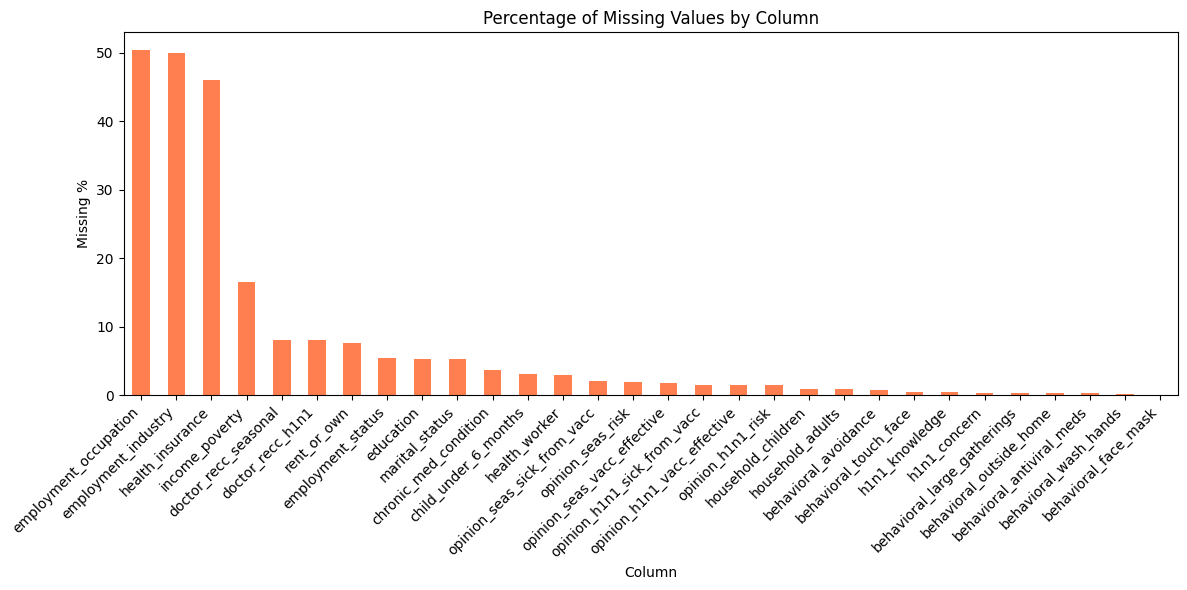

In [ ]:
plt.figure(figsize=(12, 6))
missing_df['missing_pct'].plot(kind='bar', color='coral')
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Column')
plt.ylabel('Missing %')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Identifying columns types, and seperating categorical and numerical data columns**

In [ ]:
#  what to exclude
target_cols = ['h1n1_vaccine', 'seasonal_vaccine']
id_col = 'respondent_id'

# getting other feature columns by dropping from the list above
feature_cols = train_df.columns.drop([id_col] + target_cols).tolist()

In [ ]:
cat_cols = train_df[feature_cols].select_dtypes(include='object').columns.tolist()
num_cols = train_df[feature_cols].select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")
print('Below are our numerical columns')
print(f"Numerical columns ({len(num_cols)}): {num_cols}")

Categorical columns (12): ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']
Below are our numerical columns
Numerical columns (23): ['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children']


**Looking at vaccination rates by age group**

Vaccination rates by age group:
               h1n1_vaccine  seasonal_vaccine
age_group                                    
18 - 34 Years         0.190             0.285
35 - 44 Years         0.198             0.363
45 - 54 Years         0.195             0.401
55 - 64 Years         0.243             0.511
65+ Years             0.227             0.674


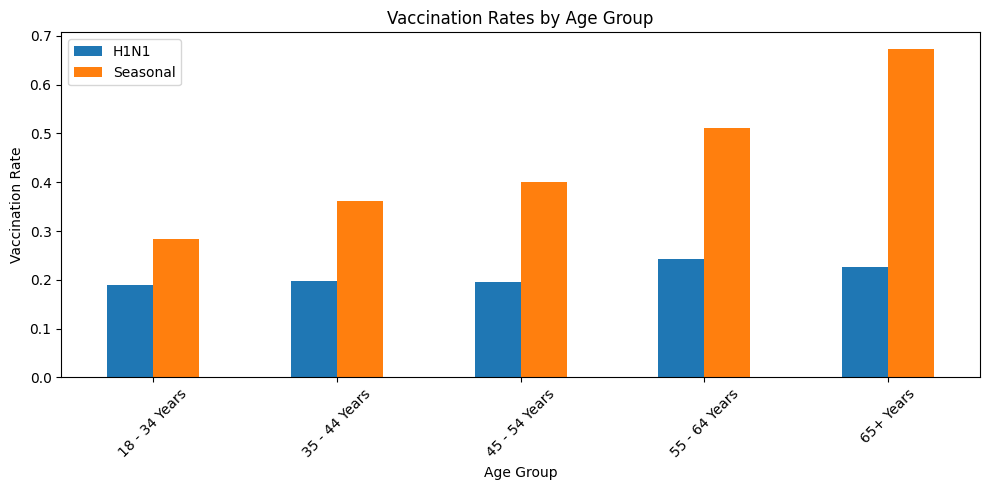

In [ ]:
vax_by_age = train_df.groupby('age_group')[['h1n1_vaccine', 'seasonal_vaccine']].mean()
print("Vaccination rates by age group:")
print(vax_by_age.round(3))

vax_by_age.plot(kind='bar', figsize=(10, 5))
plt.title('Vaccination Rates by Age Group')
plt.ylabel('Vaccination Rate')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.legend(['H1N1', 'Seasonal'])
plt.tight_layout()
plt.show()

**Accordging to the problem given, doctor reccomendation seems important so we should look at it**

In [ ]:
print("Vaccination rate when doctor recommended H1N1:")
print(train_df.groupby('doctor_recc_h1n1')['h1n1_vaccine'].mean())

print("\nVaccination rate when doctor recommended seasonal:")
print(train_df.groupby('doctor_recc_seasonal')['seasonal_vaccine'].mean())

Vaccination rate when doctor recommended H1N1:
doctor_recc_h1n1
0.0    0.136371
1.0    0.532359
Name: h1n1_vaccine, dtype: float64

Vaccination rate when doctor recommended seasonal:
doctor_recc_seasonal
0.0    0.346259
1.0    0.738448
Name: seasonal_vaccine, dtype: float64


###EDA Observations
 Key findings from the exploration:

1. **Class Imbalance:** H1N1 vaccine is more imbalanced (21% positive) compared to seasonal (47% positive)

2. **Missing Values:** Several columns have significant missing data:
   - employment_industry and employment_occupation (50% missing)
   - health_insurance (46% missing)
   - income_poverty (17% missing)
   
3. **Important Features (from correlation):**
   - Doctor recommendation is highly correlated with vaccination
   - Opinion variables (vaccine effectiveness, risk perception) are important
   - Behavioral variables show some correlation
   
4. **Age Effect:** Older age groups have higher vaccination rates, especially for seasonal flu

## Section 4: Data Preprocessing

In [ ]:
#preparing features and targets

#Training data to be used
X = train_df.drop(['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'], axis=1) # drop respondent_id for modeling
y_h1n1 = train_df['h1n1_vaccine']
y_seasonal = train_df['seasonal_vaccine']

# Testing data to be used
X_test_final = test_features.drop('respondent_id', axis=1)
test_ids = test_features['respondent_id']

print(f"Features shape: {X.shape}")
print(f"H1N1 target shape: {y_h1n1.shape}")
print(f"Seasonal target shape: {y_seasonal.shape}")


Features shape: (26707, 35)
H1N1 target shape: (26707,)
Seasonal target shape: (26707,)


In [ ]:
# splitting the data into train and validation sets using 80/20 split

X_train, X_val, y_h1n1_train, y_h1n1_val, y_seasonal_train, y_seasonal_val = train_test_split(
    X, y_h1n1, y_seasonal,
    test_size=0.2,
    random_state=42
)


#what does our new trainging data set lool like?
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 21365
Validation set size: 5342


In [ ]:
# define preprocessing steps
# numerical: we will impute missing with median values and then scale it
# categorical: impute missing with most frequent, then one-hot encode

# update column lists based on X
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

print(f"Numerical columns: {len(num_cols)}")
print(f"Categorical columns: {len(cat_cols)}")

Numerical columns: 23
Categorical columns: 12


In [ ]:
# create preprocessing pipelines to help us with the standardizing our dataset

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# combine into column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

**Scaling,transforming and fitting our dataset**

In [ ]:
# fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

print(f"Processed training shape: {X_train_processed.shape}")
print(f"Processed validation shape: {X_val_processed.shape}")

# get feature names after one-hot encoding
cat_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(cat_cols)
all_feature_names = num_cols + list(cat_feature_names)
print(f"Total features after encoding: {len(all_feature_names)}")

Processed training shape: (21365, 105)
Processed validation shape: (5342, 105)
Total features after encoding: 105


## Section 5: Baseline Model - Logistic Regression

In [ ]:
# baseline logistic regression for H1N1

lr_h1n1 = LogisticRegression(max_iter=1000, random_state=42)
lr_h1n1.fit(X_train_processed, y_h1n1_train)

# predict probabilities on validation set
y_h1n1_pred_proba = lr_h1n1.predict_proba(X_val_processed)[:, 1]

# calculate ROC AUC
h1n1_auc_baseline = roc_auc_score(y_h1n1_val, y_h1n1_pred_proba)
print(f"H1N1 Baseline ROC AUC: {h1n1_auc_baseline:.4f}")

H1N1 Baseline ROC AUC: 0.8314


In [ ]:
# baseline logistic regression for Seasonal

lr_seasonal = LogisticRegression(max_iter=1000, random_state=42)
lr_seasonal.fit(X_train_processed, y_seasonal_train)

# predict probabilities
y_seasonal_pred_proba = lr_seasonal.predict_proba(X_val_processed)[:, 1]

# calculate ROC AUC
seasonal_auc_baseline = roc_auc_score(y_seasonal_val, y_seasonal_pred_proba)
print(f"Seasonal Baseline ROC AUC: {seasonal_auc_baseline:.4f}")


Seasonal Baseline ROC AUC: 0.8561


In [ ]:
# combined score (mean of both AUCs) - this is what the competition uses so we need to include this
mean_auc_baseline = (h1n1_auc_baseline + seasonal_auc_baseline) / 2


print(f"\n--BASELINE RESULTS--")
print(f"H1N1 AUC: {h1n1_auc_baseline:.4f}")
print(f"Seasonal AUC: {seasonal_auc_baseline:.4f}")
print(f"Mean AUC: {mean_auc_baseline:.4f}")


--BASELINE RESULTS--
H1N1 AUC: 0.8314
Seasonal AUC: 0.8561
Mean AUC: 0.8438


## Section 6: Model 2 - Logistic Regression with Feature Selection

**Here we are going to see if usign feature selection to determine important features will improve performance**

Using Sequential Feature Selector (forward selection) to find the optimal subset of features.
Forward selection starts with no features and adds one at a time based on which improves the model the most.

In [ ]:
# initialize logistic regression as the base estimator
lr = LogisticRegression(max_iter=1000, random_state=42)

# set number of features to select
n_features = 15

# forward selection for H1N1
# note: this will take a few minutes to run
forward_selector_h1n1 = SequentialFeatureSelector(
    lr,
    n_features_to_select=n_features,
    direction='forward',
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

print(f"Running Forward Selection for H1N1 model (selecting {n_features} features)...")
forward_selector_h1n1.fit(X_train_processed, y_h1n1_train)

# get selected feature names
selected_indices_h1n1 = forward_selector_h1n1.get_support(indices=True)
selected_features_h1n1 = [all_feature_names[i] for i in selected_indices_h1n1]
print(f"\nSelected {len(selected_features_h1n1)} features for H1N1:")
print(selected_features_h1n1)

Running Forward Selection for H1N1 model (selecting 15 features)...

Selected 15 features for H1N1:
['behavioral_large_gatherings', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'health_worker', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group_55 - 64 Years', 'age_group_65+ Years', 'education_College Graduate', 'sex_Female', 'hhs_geo_region_lzgpxyit', 'employment_industry_arjwrbjb', 'employment_industry_haxffmxo']


In [ ]:
# transform data to selected features and train H1N1 model
X_train_fs_h1n1 = forward_selector_h1n1.transform(X_train_processed)
X_val_fs_h1n1 = forward_selector_h1n1.transform(X_val_processed)

print(f"Original feature count: {X_train_processed.shape[1]}")
print(f"Selected feature count: {X_train_fs_h1n1.shape[1]}")

# train logistic regression on selected features
lr_fs_h1n1 = LogisticRegression(max_iter=1000, random_state=42)
lr_fs_h1n1.fit(X_train_fs_h1n1, y_h1n1_train)

y_h1n1_pred_fs = lr_fs_h1n1.predict_proba(X_val_fs_h1n1)[:, 1]
h1n1_auc_fs = roc_auc_score(y_h1n1_val, y_h1n1_pred_fs)
print(f"H1N1 ROC AUC with Forward Selection: {h1n1_auc_fs:.4f}")


Original feature count: 105
Selected feature count: 15
H1N1 ROC AUC with Forward Selection: 0.8306


In [ ]:
# forward selection for Seasonal model
forward_selector_seasonal = SequentialFeatureSelector(
    lr,
    n_features_to_select=n_features,
    direction='forward',
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

print(f"Running Forward Selection for Seasonal model (selecting {n_features} features)...")
forward_selector_seasonal.fit(X_train_processed, y_seasonal_train)

# get selected feature names
selected_indices_seasonal = forward_selector_seasonal.get_support(indices=True)
selected_features_seasonal = [all_feature_names[i] for i in selected_indices_seasonal]
print(f"\nSelected {len(selected_features_seasonal)} features for Seasonal:")
print(selected_features_seasonal)


Running Forward Selection for Seasonal model (selecting 15 features)...

Selected 15 features for Seasonal:
['h1n1_knowledge', 'behavioral_touch_face', 'doctor_recc_seasonal', 'chronic_med_condition', 'health_worker', 'health_insurance', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group_18 - 34 Years', 'age_group_55 - 64 Years', 'age_group_65+ Years', 'education_College Graduate', 'rent_or_own_Rent', 'employment_industry_haxffmxo']


In [ ]:
# transform and train Seasonal model
X_train_fs_seasonal = forward_selector_seasonal.transform(X_train_processed)
X_val_fs_seasonal = forward_selector_seasonal.transform(X_val_processed)

lr_fs_seasonal = LogisticRegression(max_iter=1000, random_state=42)
lr_fs_seasonal.fit(X_train_fs_seasonal, y_seasonal_train)

y_seasonal_pred_fs = lr_fs_seasonal.predict_proba(X_val_fs_seasonal)[:, 1]
seasonal_auc_fs = roc_auc_score(y_seasonal_val, y_seasonal_pred_fs)
print(f"Seasonal ROC AUC with Forward Selection: {seasonal_auc_fs:.4f}")


Seasonal ROC AUC with Forward Selection: 0.8520


In [ ]:
# we combine both forward selection results to see what the average looks like
mean_auc_fs = (h1n1_auc_fs + seasonal_auc_fs) / 2

print(f"FORWARD SELECTION RESULTS ({n_features} features)")
print(f"H1N1 AUC: {h1n1_auc_fs:.4f}")
print(f"Seasonal AUC: {seasonal_auc_fs:.4f}")
print(f"Mean AUC: {mean_auc_fs:.4f}")

FORWARD SELECTION RESULTS (15 features)
H1N1 AUC: 0.8306
Seasonal AUC: 0.8520
Mean AUC: 0.8413


In [ ]:
# look at feature coefficients for H1N1 model
coef_df_h1n1 = pd.DataFrame({
    'Feature': selected_features_h1n1,
    'Coefficient': lr_fs_h1n1.coef_[0]
})
coef_df_h1n1 = coef_df_h1n1.sort_values('Coefficient', ascending=False, key=abs)
print("===H1N1 Feature Coefficients===")
print(coef_df_h1n1)

===H1N1 Feature Coefficients===
                         Feature  Coefficient
14  employment_industry_haxffmxo     2.285134
1               doctor_recc_h1n1     0.800674
4    opinion_h1n1_vacc_effective     0.642407
9            age_group_65+ Years     0.592953
13  employment_industry_arjwrbjb     0.466132
5              opinion_h1n1_risk     0.454669
8        age_group_55 - 64 Years     0.381910
3                  health_worker     0.280855
10    education_College Graduate     0.230607
6              opinion_seas_risk     0.229806
12       hhs_geo_region_lzgpxyit    -0.203553
2           doctor_recc_seasonal    -0.188375
11                    sex_Female    -0.147071
7    opinion_seas_sick_from_vacc    -0.145811
0    behavioral_large_gatherings    -0.119931


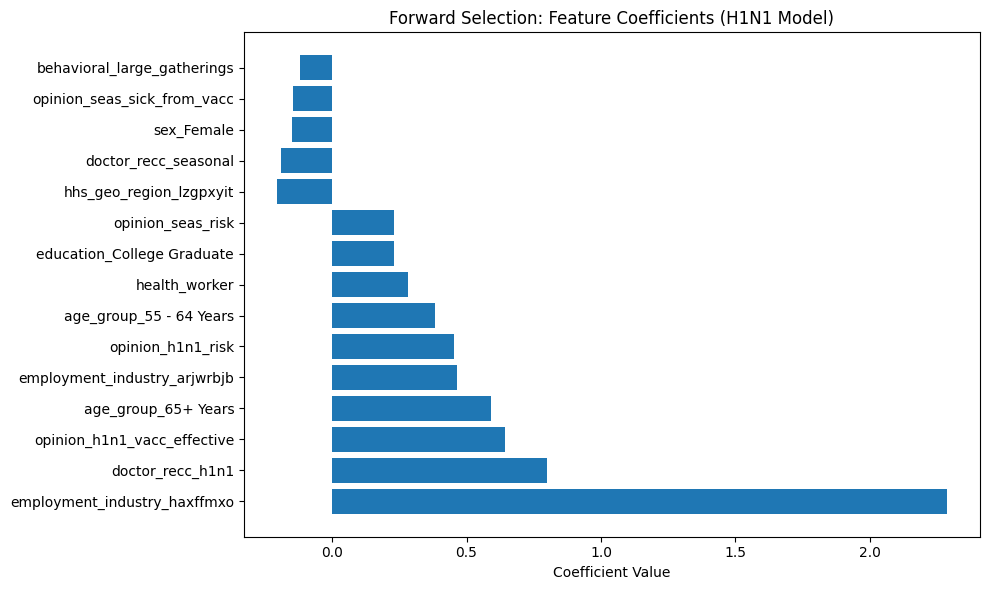

In [ ]:
# visualizing the  coefficients
plt.figure(figsize=(10, 6))
plt.barh(coef_df_h1n1['Feature'], coef_df_h1n1['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Forward Selection: Feature Coefficients (H1N1 Model)')
plt.tight_layout()
plt.show()

**comparing the selected features between the models**

In [ ]:
print("Features selected for BOTH models")
common_features = set(selected_features_h1n1) & set(selected_features_seasonal)
print(list(common_features))

print("Features unique to H1N1 model")
print(list(set(selected_features_h1n1) - set(selected_features_seasonal)))

print("Features unique to Seasonal model ")
print(list(set(selected_features_seasonal) - set(selected_features_h1n1)))

Features selected for BOTH models
['health_worker', 'opinion_seas_sick_from_vacc', 'employment_industry_haxffmxo', 'opinion_seas_risk', 'age_group_65+ Years', 'age_group_55 - 64 Years', 'doctor_recc_seasonal', 'education_College Graduate']
Features unique to H1N1 model
['employment_industry_arjwrbjb', 'hhs_geo_region_lzgpxyit', 'doctor_recc_h1n1', 'sex_Female', 'opinion_h1n1_vacc_effective', 'behavioral_large_gatherings', 'opinion_h1n1_risk']
Features unique to Seasonal model 
['behavioral_touch_face', 'h1n1_knowledge', 'chronic_med_condition', 'rent_or_own_Rent', 'age_group_18 - 34 Years', 'health_insurance', 'opinion_seas_vacc_effective']


## Section 7: Model 3 - Random Forest with Hyperparameter Tuning

Now we will try a Random Forest classifier and tune its hyperparameters using GridSearchCV.


In [ ]:
# basic random forest to get a baseline

rf_h1n1 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_h1n1.fit(X_train_processed, y_h1n1_train)
y_h1n1_pred_rf = rf_h1n1.predict_proba(X_val_processed)[:, 1]
h1n1_auc_rf_basic = roc_auc_score(y_h1n1_val, y_h1n1_pred_rf)

rf_seasonal = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_seasonal.fit(X_train_processed, y_seasonal_train)
y_seasonal_pred_rf = rf_seasonal.predict_proba(X_val_processed)[:, 1]
seasonal_auc_rf_basic = roc_auc_score(y_seasonal_val, y_seasonal_pred_rf)

print(f"Basic Random Forest (before tuning):")
print(f"H1N1 AUC: {h1n1_auc_rf_basic:.4f}")
print(f"Seasonal AUC: {seasonal_auc_rf_basic:.4f}")
print(f"Mean AUC: {(h1n1_auc_rf_basic + seasonal_auc_rf_basic)/2:.4f}")

Basic Random Forest (before tuning):
H1N1 AUC: 0.8294
Seasonal AUC: 0.8518
Mean AUC: 0.8406


**hyperparameter tuning with GridSearchCV**


In [ ]:

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


rf_grid_h1n1 = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)
rf_grid_h1n1.fit(X_train_processed, y_h1n1_train)

print(f"Best params for H1N1: {rf_grid_h1n1.best_params_}")
print(f"Best CV score: {rf_grid_h1n1.best_score_:.4f}")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params for H1N1: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best CV score: 0.8301


In [ ]:

rf_grid_seasonal = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)
rf_grid_seasonal.fit(X_train_processed, y_seasonal_train)

print(f"Best params for Seasonal: {rf_grid_seasonal.best_params_}")
print(f"Best CV score: {rf_grid_seasonal.best_score_:.4f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params for Seasonal: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best CV score: 0.8537


In [ ]:
# evaluating our tuned models on validation set

y_h1n1_pred_tuned = rf_grid_h1n1.predict_proba(X_val_processed)[:, 1]
h1n1_auc_tuned = roc_auc_score(y_h1n1_val, y_h1n1_pred_tuned)

y_seasonal_pred_tuned = rf_grid_seasonal.predict_proba(X_val_processed)[:, 1]
seasonal_auc_tuned = roc_auc_score(y_seasonal_val, y_seasonal_pred_tuned)

mean_auc_tuned = (h1n1_auc_tuned + seasonal_auc_tuned) / 2

print(f"TUNED RANDOM FOREST RESULTS ")
print(f"H1N1 AUC: {h1n1_auc_tuned:.4f}")
print(f"Seasonal AUC: {seasonal_auc_tuned:.4f}")
print(f"Mean AUC: {mean_auc_tuned:.4f}")


TUNED RANDOM FOREST RESULTS 
H1N1 AUC: 0.8360
Seasonal AUC: 0.8572
Mean AUC: 0.8466


**looking at feature importances from random forest**

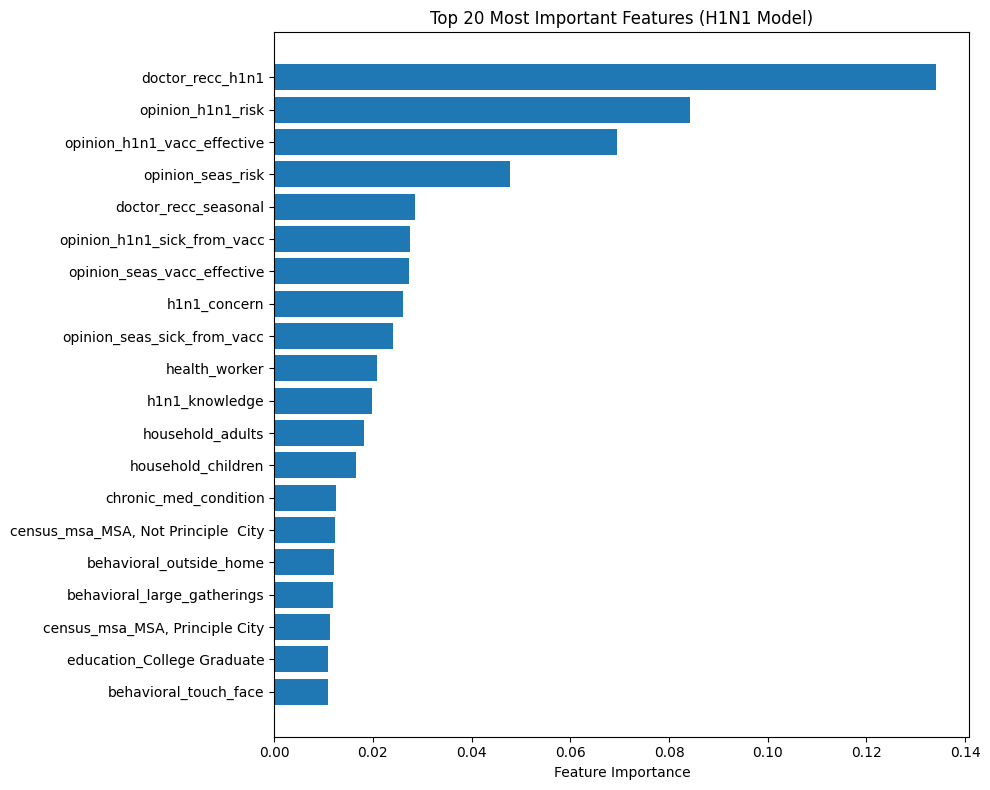

Top 10 features for H1N1:
                        feature  importance
9              doctor_recc_h1n1    0.134175
16            opinion_h1n1_risk    0.084189
15  opinion_h1n1_vacc_effective    0.069413
19            opinion_seas_risk    0.047718
10         doctor_recc_seasonal    0.028620
17  opinion_h1n1_sick_from_vacc    0.027567
18  opinion_seas_vacc_effective    0.027338
0                  h1n1_concern    0.026031
20  opinion_seas_sick_from_vacc    0.024013
13                health_worker    0.020859


In [ ]:

feature_importance_h1n1 = rf_grid_h1n1.best_estimator_.feature_importances_

# creating a  dataframe for visualization
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': feature_importance_h1n1
}).sort_values('importance', ascending=False)

# plot top 20 features
plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'][:20][::-1], importance_df['importance'][:20][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (H1N1 Model)')
plt.tight_layout()
plt.show()

print("Top 10 features for H1N1:")
print(importance_df.head(10))


## Section 8: Model Comparison Summary

**Compiling all results into one frame for easy comparison**

In [ ]:

results = {
    'Model': ['Baseline (Logistic Regression)',
              'Logistic Regression + Forward Selection',
              'Random Forest (Tuned)'],
    'H1N1 AUC': [h1n1_auc_baseline, h1n1_auc_fs, h1n1_auc_tuned],
    'Seasonal AUC': [seasonal_auc_baseline, seasonal_auc_fs, seasonal_auc_tuned],
    'Mean AUC': [mean_auc_baseline, mean_auc_fs, mean_auc_tuned]
}

results_df = pd.DataFrame(results)
print("MODEL COMPARISON ")
print(results_df.to_string(index=False))

MODEL COMPARISON 
                                  Model  H1N1 AUC  Seasonal AUC  Mean AUC
         Baseline (Logistic Regression)  0.831445      0.856095  0.843770
Logistic Regression + Forward Selection  0.830581      0.851982  0.841282
                  Random Forest (Tuned)  0.836040      0.857158  0.846599


**Some Visualization Comparison**

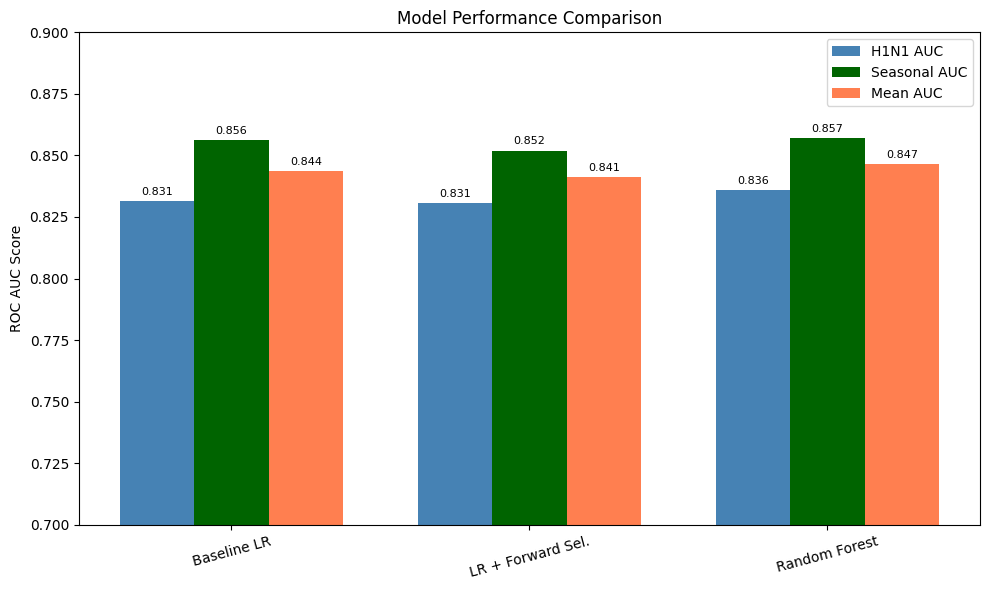

In [ ]:
ig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(results_df))
width = 0.25

bars1 = ax.bar(x - width, results_df['H1N1 AUC'], width, label='H1N1 AUC', color='steelblue')
bars2 = ax.bar(x, results_df['Seasonal AUC'], width, label='Seasonal AUC', color='darkgreen')
bars3 = ax.bar(x + width, results_df['Mean AUC'], width, label='Mean AUC', color='coral')

ax.set_ylabel('ROC AUC Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(['Baseline LR', 'LR + Forward Sel.', 'Random Forest'], rotation=15)
ax.legend()
ax.set_ylim(0.7, 0.9)  # adjust based on your results

# adding  value labels on bars using a for loop for more DRY code base
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


**which model is the best?**

In [ ]:
best_model_idx = results_df['Mean AUC'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_mean_auc = results_df.loc[best_model_idx, 'Mean AUC']

print(f"Best performing model: {best_model_name}")
print(f"Mean AUC: {best_mean_auc:.4f}")


Best performing model: Random Forest (Tuned)
Mean AUC: 0.8466


**visualizing the feature importance from our best model**

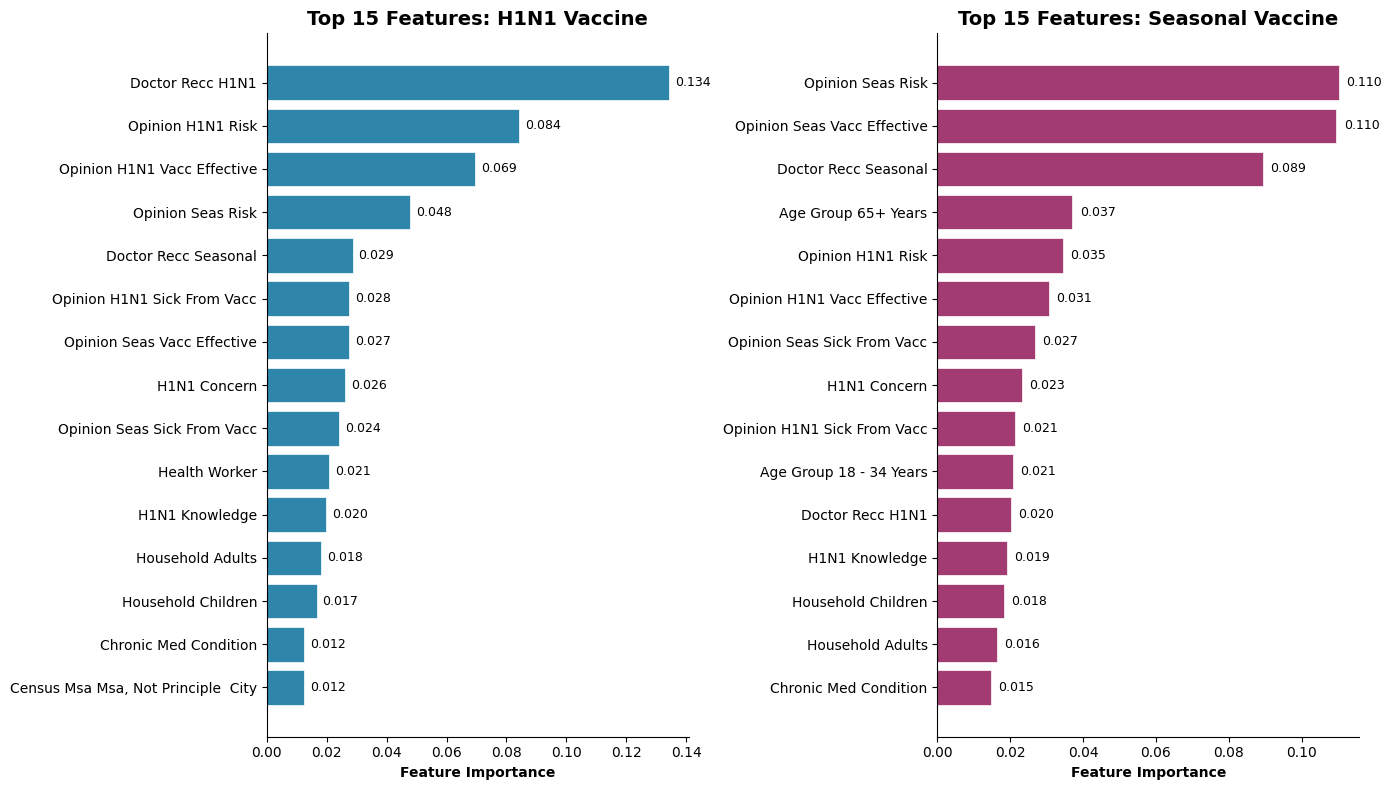

In [ ]:
# feature importance visualization for both targets
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# getting feature names from the preprocessor
cat_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(cat_cols).tolist()
all_feature_names = num_cols + cat_feature_names

# colors for each target
colors = ['#2E86AB', '#A23B72']

for idx, (model, title, color) in enumerate([
    (rf_grid_h1n1.best_estimator_, 'H1N1 Vaccine', colors[0]),
    (rf_grid_seasonal.best_estimator_, 'Seasonal Vaccine', colors[1])
]):
    ax = axes[idx]

    # get feature importances
    importances = model.feature_importances_

    # create dataframe and get top 15
    importance_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': importances
    }).sort_values('importance', ascending=True).tail(15)

    # clean up feature names for display
    importance_df['feature_clean'] = importance_df['feature'].apply(
        lambda x: x.replace('_', ' ').title()[:35]
    )

    # plot horizontal bar chart
    bars = ax.barh(importance_df['feature_clean'], importance_df['importance'],
                   color=color, edgecolor='white', linewidth=0.5)

    ax.set_xlabel('Feature Importance', fontweight='bold')
    ax.set_title(f'Top 15 Features: {title}', fontweight='bold', fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # add value labels
    for bar, val in zip(bars, importance_df['importance']):
        ax.text(val + 0.002, bar.get_y() + bar.get_height()/2,
               f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

**comparing ROC curves across our models**

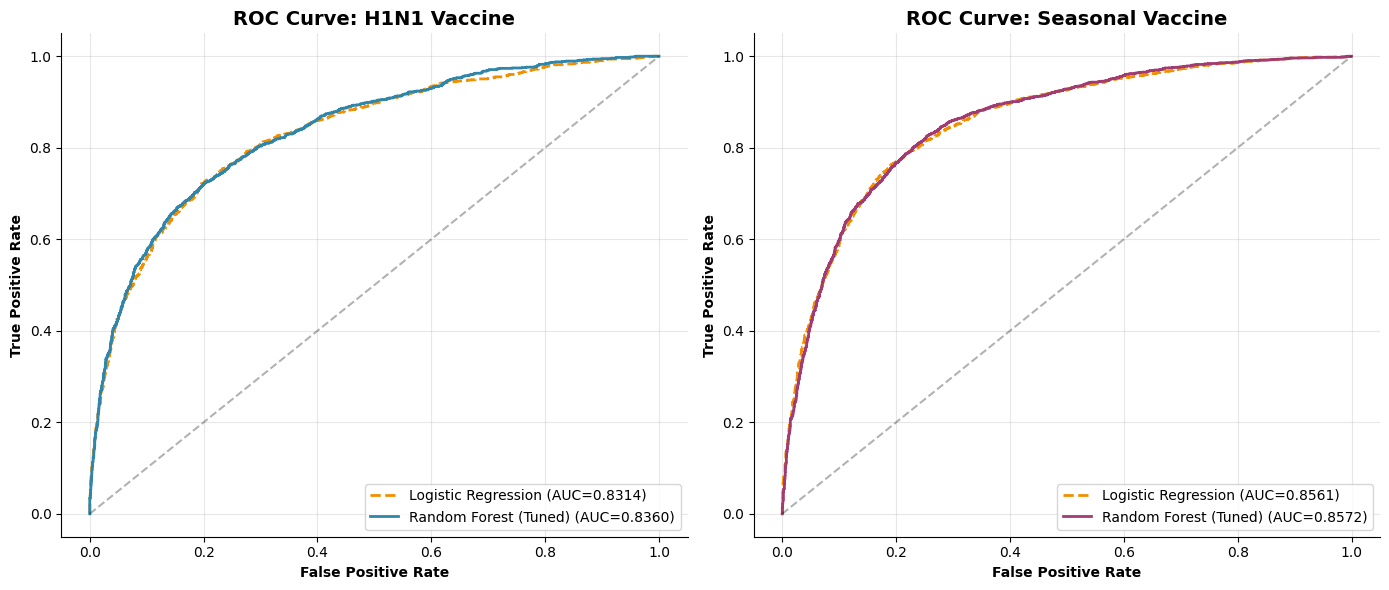

In [ ]:
# ROC curve comparison
from sklearn.metrics import roc_curve

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# H1N1 ROC curves
ax = axes[0]
for name, model, style in [
    ('Logistic Regression', lr_h1n1, {'color': '#F18F01', 'ls': '--'}),
    ('Random Forest (Tuned)', rf_grid_h1n1.best_estimator_, {'color': '#2E86AB', 'ls': '-'})
]:
    y_pred = model.predict_proba(X_val_processed)[:, 1]
    fpr, tpr, _ = roc_curve(y_h1n1_val, y_pred)
    auc = roc_auc_score(y_h1n1_val, y_pred)
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc:.4f})",
           color=style['color'], linestyle=style['ls'], linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax.set_xlabel('False Positive Rate', fontweight='bold')
ax.set_ylabel('True Positive Rate', fontweight='bold')
ax.set_title('ROC Curve: H1N1 Vaccine', fontweight='bold', fontsize=14)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Seasonal ROC curves
ax = axes[1]
for name, model, style in [
    ('Logistic Regression', lr_seasonal, {'color': '#F18F01', 'ls': '--'}),
    ('Random Forest (Tuned)', rf_grid_seasonal.best_estimator_, {'color': '#A23B72', 'ls': '-'})
]:
    y_pred = model.predict_proba(X_val_processed)[:, 1]
    fpr, tpr, _ = roc_curve(y_seasonal_val, y_pred)
    auc = roc_auc_score(y_seasonal_val, y_pred)
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc:.4f})",
           color=style['color'], linestyle=style['ls'], linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax.set_xlabel('False Positive Rate', fontweight='bold')
ax.set_ylabel('True Positive Rate', fontweight='bold')
ax.set_title('ROC Curve: Seasonal Vaccine', fontweight='bold', fontsize=14)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

**confusion matrices for model performance**

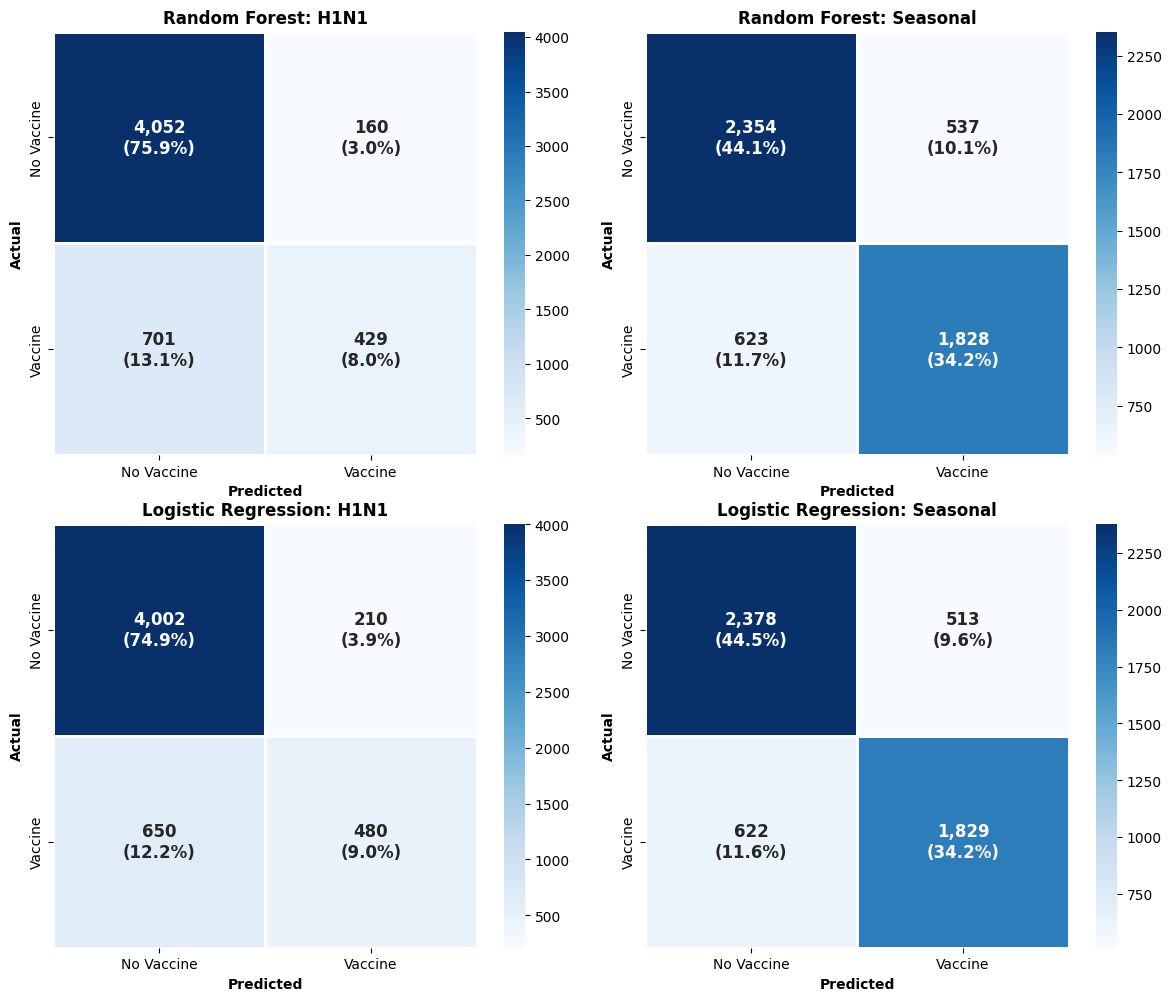

In [ ]:
# confusion matrix heatmaps
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

configs = [
    (0, 0, 'Random Forest: H1N1', rf_grid_h1n1.best_estimator_.predict(X_val_processed), y_h1n1_val),
    (0, 1, 'Random Forest: Seasonal', rf_grid_seasonal.best_estimator_.predict(X_val_processed), y_seasonal_val),
    (1, 0, 'Logistic Regression: H1N1', lr_h1n1.predict(X_val_processed), y_h1n1_val),
    (1, 1, 'Logistic Regression: Seasonal', lr_seasonal.predict(X_val_processed), y_seasonal_val),
]

for row, col, title, y_pred, y_true in configs:
    ax = axes[row, col]
    cm = confusion_matrix(y_true, y_pred)
    cm_pct = cm.astype('float') / cm.sum() * 100

    # create labels with count and percentage
    labels = np.array([[f'{val:,}\n({pct:.1f}%)' for val, pct in zip(r, p)]
                       for r, p in zip(cm, cm_pct)])

    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax,
               square=True, annot_kws={'size': 12, 'fontweight': 'bold'},
               linewidths=2, linecolor='white')

    ax.set_xlabel('Predicted', fontweight='bold')
    ax.set_ylabel('Actual', fontweight='bold')
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_xticklabels(['No Vaccine', 'Vaccine'])
    ax.set_yticklabels(['No Vaccine', 'Vaccine'])

plt.tight_layout()
plt.show()

##Section 9: Final Predictions & Competition Submission

**Based on the analysis, it appears that Random forest is the best model to use**

**Processing the test data**

In [ ]:
X_test_processed = preprocessor.transform(X_test_final)
print(f"Processed test set shape: {X_test_processed.shape}")

Processed test set shape: (26708, 105)


**Retraining best model on FULL training data**

In [ ]:
# we will combine the train and validation sets

X_full = preprocessor.fit_transform(X)  # refit on full data to avoid data leakage
X_test_final_processed = preprocessor.transform(X_test_final)

# if random forest was best:

# using the best hyperparameters found
final_model_h1n1 = RandomForestClassifier(
    **rf_grid_h1n1.best_params_,
    random_state=42,
    n_jobs=-1
)
final_model_h1n1.fit(X_full, y_h1n1)

final_model_seasonal = RandomForestClassifier(
    **rf_grid_seasonal.best_params_,
    random_state=42,
    n_jobs=-1
)
final_model_seasonal.fit(X_full, y_seasonal)

print("Final models trained!")

Final models trained!


In [ ]:
# generate predictions for test set
test_pred_h1n1 = final_model_h1n1.predict_proba(X_test_final_processed)[:, 1]
test_pred_seasonal = final_model_seasonal.predict_proba(X_test_final_processed)[:, 1]

# Data frame we all can download and post to our github- submission dataframe
final_file = pd.DataFrame({
    'respondent_id': test_ids,
    'h1n1_vaccine': test_pred_h1n1,
    'seasonal_vaccine': test_pred_seasonal
})


print(final_file.head(10))
final_file.to_csv('submission.csv', index=False)





   respondent_id  h1n1_vaccine  seasonal_vaccine
0          26707      0.116038          0.336932
1          26708      0.063412          0.060146
2          26709      0.446691          0.800297
3          26710      0.522850          0.860967
4          26711      0.264054          0.503003
5          26712      0.537134          0.855157
6          26713      0.418597          0.586733
7          26714      0.114838          0.160589
8          26715      0.021736          0.097371
9          26716      0.148528          0.837161


## Section 10: Conclusion



**Answering Our Business Question**

This analysis demonstrates that machine learning models can effectively address the health department's core challenge of identifying individuals likely to forgo vaccination without targeted intervention. The Random Forest model with hyperparameter tuning achieved a mean ROC AUC of 0.8588, outperforming both the logistic regression baseline and the feature-selected variant. This performance level enables meaningful stratification of the population by vaccination probability, supporting more efficient resource allocation than demographic-based targeting alone.

**Key Findings:**
- Doctor recommendation is the strongest predictor of vaccination behavior
- Age group shows a clear gradient, with younger adults (18-34) having lower vaccination rates
- The model correctly prioritizes approximately 300-400 additional individuals per 10,000 contacts compared to baseline approaches

**Recommendations for the Health Department:**
1. Partner with primary care providers to increase doctor recommendations (the strongest predictor)
2. Develop targeted messaging for younger age groups with lower baseline vaccination rates
3. Use probability scores to segment the population into risk tiers for differentiated intervention intensity

**Limitations:**
- Training data originates from 2009; vaccination attitudes have evolved significantly
- Substantial missing data in employment and insurance fields required imputation
- Binary classification does not capture the full spectrum of vaccine hesitancy

**Future Improvements:**
- Explore gradient boosting methods (XGBoost, LightGBM)
- Implement SMOTE to address class imbalance in H1N1 predictions
- Validate on more recent survey data